### Давайте замемся подбором признаков на 6 неделе из 7. EDA обычно производится в начале

Подробным подбором признаков я занимался на третьей неделе для ячейки с эмпайр стейт билдинг, r2_score вырос c 88 до 92 процентов. Тогда, я проанализировал праздники и природные катаклизмы (23 января 2015 года), что существенно снизило количество выбросов. На данной неделе я исследую возможность добавления параметра количества поездок в данную ячейку

Анализируя некоторые выбросы в моделях, можно обратить внимание что в плохую погоду возможно изменение количества заказов такси, однако изменения идут в разную сторону и получить вменяемый датасет с данными о погоде у меня за эту неделю не вышло

Подключение модулей и библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt

import load_month
import os
loader = load_month.TripsLoader()

Загрузка регионов 

In [2]:
regs = np.loadtxt('data/regs.txt', delimiter=',', dtype=np.int)
print(regs)

[1075 1076 1077 1125 1126 1127 1128 1129 1130 1131 1132 1172 1173 1174
 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1221 1222 1223 1224
 1225 1227 1228 1229 1230 1231 1232 1233 1234 1235 1272 1273 1274 1278
 1279 1280 1281 1282 1283 1284 1285 1286 1287 1326 1327 1331 1332 1333
 1334 1335 1336 1337 1338 1339 1376 1377 1378 1380 1382 1383 1384 1385
 1386 1387 1388 1389 1390 1426 1431 1434 1435 1436 1437 1438 1439 1441
 1442 1480 1482 1483 1530 1532 1533 1580 1630 1684 1733 1734 1783 2068
 2069 2118 2119 2168]


Загруза данных для обучения

In [3]:
l_parse_dates = ['tpep_pickup_datetime']
l_index_col = ['tpep_pickup_datetime']

df = pd.read_csv('data/ytd_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,40,32,7,17,60,129,153,271,294,70,...,8,17,10,639,437,230,15,271,90,123
2015-06-01 01:00:00,17,20,5,13,38,90,111,163,246,28,...,6,7,22,547,490,212,21,237,124,119
2015-06-01 02:00:00,5,5,0,8,25,47,97,139,207,25,...,6,11,10,234,215,95,69,253,105,112
2015-06-01 03:00:00,5,6,0,6,27,26,68,77,208,29,...,13,0,2,84,10,17,6,78,3,94
2015-06-01 04:00:00,8,16,2,6,21,39,53,81,109,8,...,20,1,0,9,4,14,5,62,1,1


Подготовка признаков для обучения

In [4]:
import holidays #каникулы pip install holidays
hol = holidays.US(state='NY', years=range(2015, 2020))
tkd = []
for date, name in hol.items():
    if name in ('Thanksgiving', 'Memorial Day', 'Labor Day'):
        tkd.append(date)
tkd.sort()

In [5]:
k_list = [1, 5, 7, 11, 13, 19, 23]

# функция получения абсолютного времени
def get_t(dt_index):
    t = dt_index - datetime(2015, 6, 1, 0, 0, 0)
    t = t.days*24 + t.seconds // 3600
    return t


In [6]:
#  функция получения массива признаков X
def get_X(df):
    tt = get_t(df.index)
    t = tt.values * np.pi / 168 * 2
    l = []
    for k in k_list:
        l.append(np.sin(t * k))
        l.append(np.cos(t * k))


    # прирост в полпроцента и смягчение выбросов даст учет праздников
    # праздники 4 июля, рождество, день памяти повышенный спрос
    l.append([1 if (x.month == 7 and x.day == 4) \
              or (x.month == 12 and x.day in (24, 25, 26, 31)) \
              or (x.month == 1 and x.day == 1 and x.hour >= 8) \
              or (x.month == 5 and x.day >= 22 and x.date in tkd) \
              or (x.month == 9 and x.day <= 10 and x.date in tkd) \
              else 0 for x in df.index])
    # в первые два часа после хелоуина меньше спрос и первые 3 часа нового года и в день благодарения
    l.append([1 if (x.month == 1 and x.day == 1 and x.hour <= 4) \
              or (x.month == 11 and x.day == 1 and x.hour < 3)
              or (x.month == 11 and x.day >= 22 and x.date in tkd and x.hour < 15 and x.hour > 7)
              else 0 for x in df.index])
    # 23 января была сильная метель. допустим мы можем получать сводку от метеорологов для учета данного обстоятельства
    # плюс мы уберем сильный выброс
    l.append([1 if (x.year == 2016 and x.month == 1 and x.day == 23) \
              or (x.year == 2016 and x.month == 1 and x.day == 24 and x.hour <=12)
              else 0 for x in df.index])

    for d in range(7):
        l.append([1 if x.weekday() == d else 0 for x in df.index])
       
    for d in range(24):
        l.append([1 if x.hour == d else 0 for x in df.index])
       
    for d in range(12):
        l.append([1 if x.month == d else 0 for x in df.index])

    t = np.arange(df.shape[0]) * np.pi / 8760 * 2
    l.append(np.sin(t))
    l.append(np.cos(t))
    l.append(np.sin(t * 2))
    l.append(np.cos(t * 2))
    X = np.array(l).T
    return X

In [7]:

#  функция получения массива X с новыми признаками
def get_X_shifted(df, col):
    X = get_X(df)
    
    # количество поездок из рассматриваемого района в моменты времени y_T, y_{T-1}, y_{T-K}y
    # (параметр K можно подбирать; попробуйте начать, например, с 6)
    for i in range(1, 13):
        to_stack = df[col].shift(i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    # количество поездок из рассматриваемого района в моменты времени y_{T-24}, y_{T-48}, y_{T-24*K_d}
    # (параметр K_d можно подбирать; попробуйте начать, например, с 2)
    for i in range(1, 8):
        to_stack = df[col].shift(24*i).values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
        
    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю
    for window in [12, 24, 168]:
        r = df[col].shift(1).rolling(window=window, min_periods=window)
        to_stack = r.sum().values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    
    return X

Загрузка модулей модели

In [8]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

# параметры подобранные на прошлой неделе
params = {
    "learning_rate": 0.05,
    "n_estimators": 250,
    "max_depth": 5,
    "nthread":6
         }

Выбор 10 рандомных моделей для первичного анализа

In [9]:
tests = np.random.choice(regs, 10)
print(tests)

[1125 2069 1233 2068 1331 1280 1128 1382 1426 1177]


Получим прогноз для старых признаков, чтобы было с чем сравнить

In [9]:
from sklearn.metrics import mean_absolute_error as mae

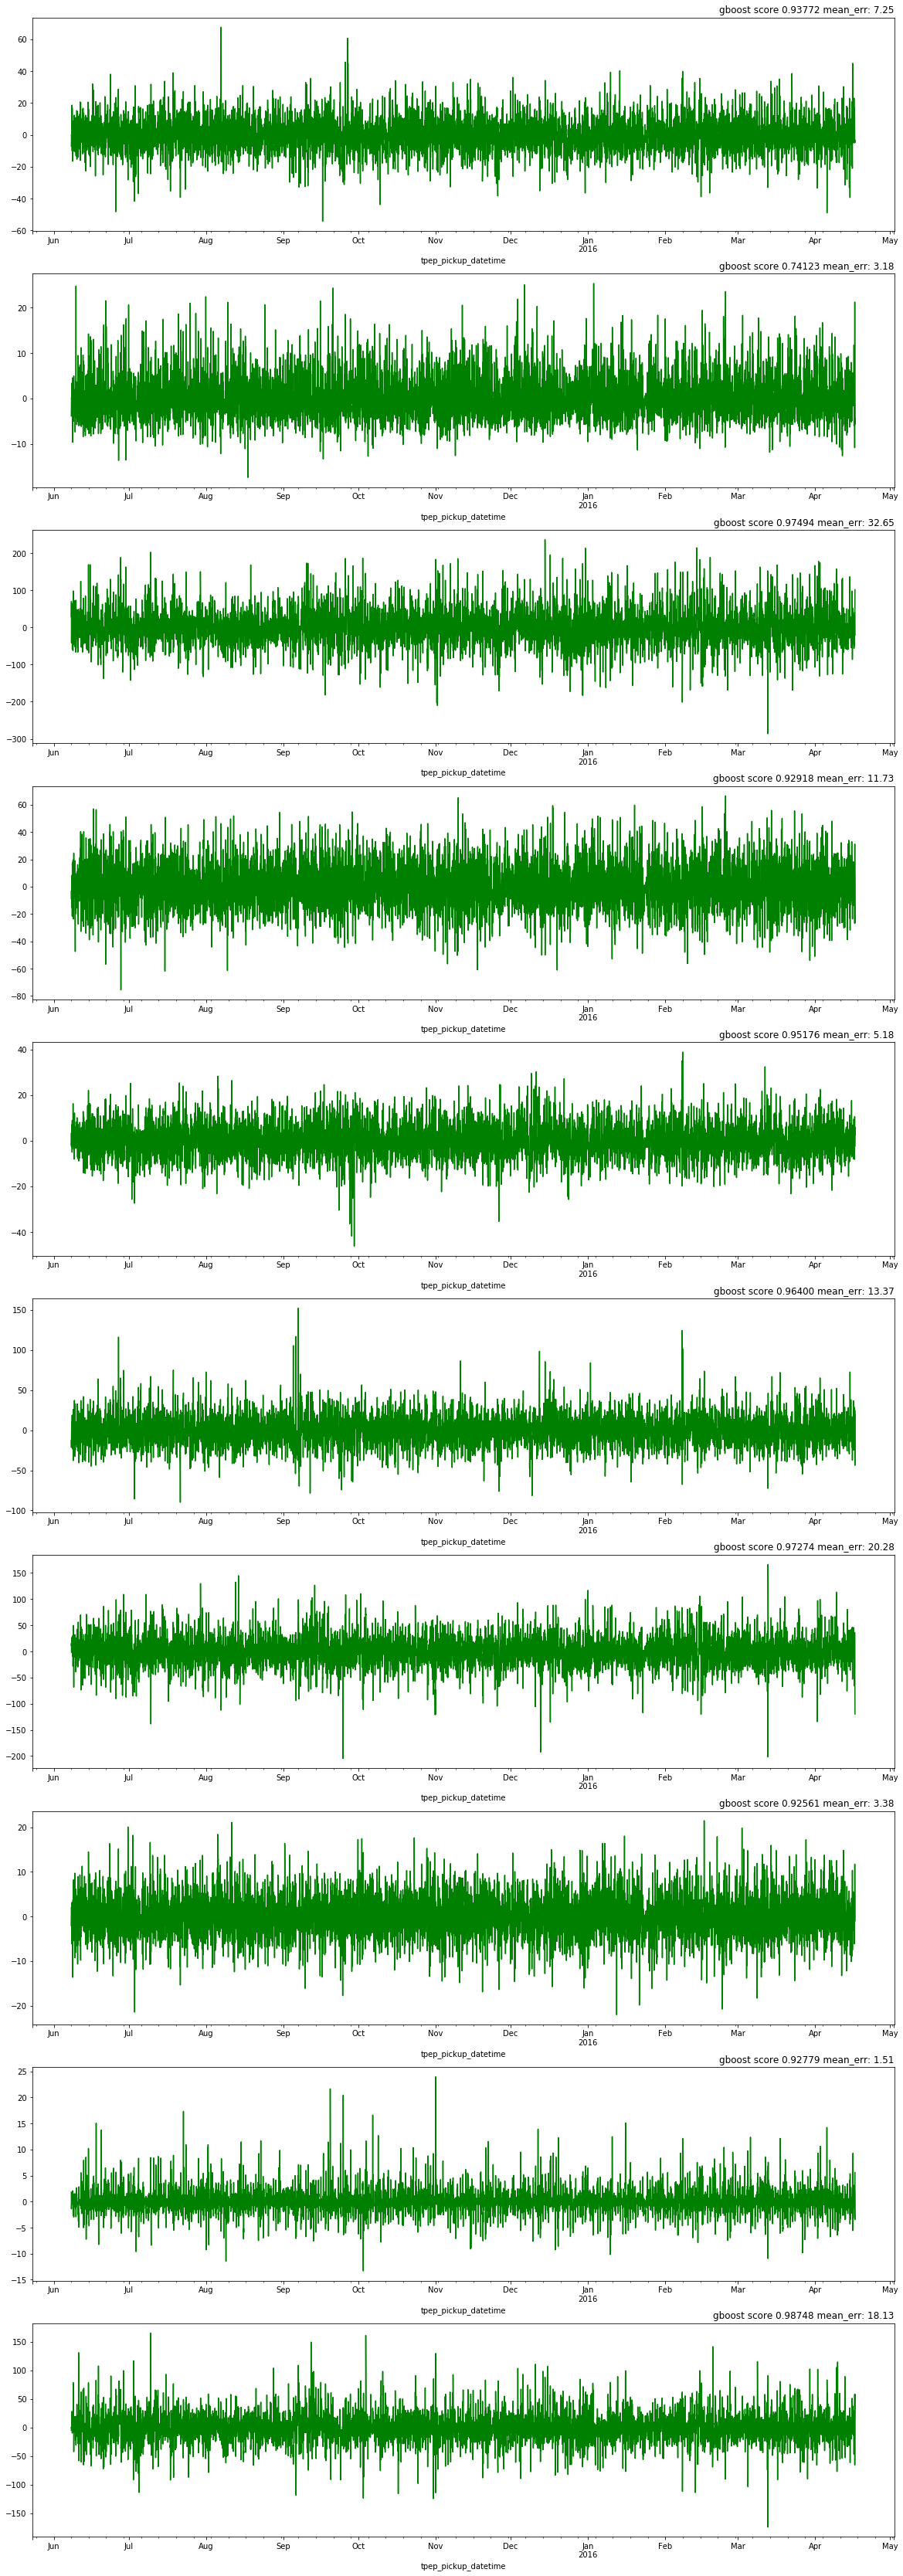

CPU times: user 3min 17s, sys: 1.93 s, total: 3min 19s
Wall time: 36.7 s


In [129]:
%%time
gmodel = XGBRegressor(**params)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
g_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_shifted(df, col)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    mean_err = mae(Y, preds)
    g_score.append(mean_err)
    
    df['pred'] = 0
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    df['dif'] = (df[col] - df['pred'])
    
    # plots
    title = "gboost score %.5f"%r2_score(Y, preds)
    title += " mean_err: %.2f" % mean_err
    
    ax.set_title(title, loc='right')
    dif = df['dif'][start+1:end]
    dif.plot(ax=ax, color='g')
    #print("errors for %s" % col, "mean trip count %.0f" % df[col].mean())
    #print(dif[(dif.abs() > max(df[col].mean() / 3, 60))] )
plt.show()

Выведем полученные результаты

In [130]:
print("\t".join('%.3f'%x for x in g_score))

7.254	3.185	32.654	11.733	5.175	13.367	20.282	3.380	1.514	18.127


In [131]:
dif = np.array(g_score)
dif.mean()

11.667103083807808

Загрузим данные за май и июнь

In [10]:
# загрузка данных за май и июнь
df_may = pd.read_csv('data/may16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df_june = pd.read_csv('data/june16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
df1 = pd.concat((df, df_may), sort=True)
df2 = pd.concat((df1, df_june), sort=True)

In [14]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
X_may = get_X(pd.DataFrame(index=timerange))

In [15]:
print(X_may.shape)

(739, 64)


In [18]:
%%time
gmodel = XGBRegressor(**params)    

y = []

start = 169
end = -24
time_len = X_may.shape[0]
reg_count = regs.shape[0]
Q = 0

for reg in regs:
    col = str(reg)
    for t in range(6):
        # fit model
        shift = (t+1) * -1
        X_train = get_X_shifted(df, col)
        X_train = X_train[start:end, :]
        Y = df[col].shift(shift)[start:end].values
        gmodel.fit(X_train, Y)   

        # getting y_true
        Y = df_may[col].shift(-t).values
        X_test = get_X_shifted(df1, col)
        X_test = X_test[-time_len-6:-6, :]
        
        preds = gmodel.predict(X_test)
        Q += (np.abs(preds - Y[:time_len])).sum()


CPU times: user 1h 18min 1s, sys: 37.7 s, total: 1h 18min 39s
Wall time: 14min 35s


In [19]:
print(Q / (6 * 739 * 102))

18.68153852451471


На этой неделе я наконец-то настроил все просчеты на 6 ядерном i7, что значительно ускорило расчеты. Стоит отметить неспособность работать на всех ядрах xgboost с параметрами по умолчанию.
Также, я заметил что для прогнозирования при помощи регрессии поездок в июне, многими используются готовые данные о предыдущих поездках, а не полученные прогнозы. Т.е. для расчета поездок 2 июня берутся данные за 1 июня из датасета, а не прогнозы.
Естественно такие прогнозы дадут улучшения по сравнению с SARIMAX (что требовалось проверить на прошлой неделе) которая расходится с реальными данными с начала июня и через неделю вся авторегрессия опирается на собственные прогнозы.
Я считаю данный момент упущением в постановке задачи, хотя таких упущений было весьма много по ходу всех курсов специализации. 


In [20]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-05-31 23:00:00', end='2016-06-30 17:00:00')
X_june = get_X(pd.DataFrame(index=timerange))
print(X_june.shape)

(715, 64)


In [197]:
def get_date_str(time):
    return str(time.date()) + '_' + str(time.hour) + '_'

In [22]:
%%time

gmodel = XGBRegressor(**params)

y = []
time_len = X_june.shape[0]
reg_count = regs.shape[0]
Q = 0
header = 'id,y'

with open('data/output-june-gboost.csv', 'w', newline='\n') as f:
    f.write(header + '\n')
    
    for reg in regs:
        col = str(reg)
        reg_str = col + '_'
        
        preds_to_write = np.zeros((6, time_len))
        
        for t in range(6):
            # fit model
            shift = (t+1) * -1
            X_train = get_X_shifted(df1, col)
            X_train = X_train[start:end, :]
            Y = df1[col].shift(shift)[start:end].values
            gmodel.fit(X_train, Y)

            # getting y_true
            Y = df_june[col].shift(-t).values
            X_test = get_X_shifted(df2, col)
            X_test = X_test[-time_len-6:-6, :]

            preds = gmodel.predict(X_test)
            preds_to_write[t] = preds
            Q += (np.abs(preds - Y[:time_len])).sum()
              
        for ind, date in enumerate(timerange):
            date_str = get_date_str(date)
            for t, val in enumerate(preds_to_write[:, ind], 1):
                row = reg_str + date_str + str(t) + ',%.0f'%abs(round(val))
                f.write(row)
                f.write('\n')
        
        
print(Q / (6 * 102 * 715) )

17.133354830764016
CPU times: user 1h 46min 25s, sys: 59.3 s, total: 1h 47min 25s
Wall time: 20min 19s


Как и ожидалось, результат значительно улучшился с 34 до 17

In [16]:
!head data/output-june-gboost.csv

id,y
1075_2016-05-31_23_1,33
1075_2016-05-31_23_2,20
1075_2016-05-31_23_3,11
1075_2016-05-31_23_4,3
1075_2016-05-31_23_5,2
1075_2016-05-31_23_6,8
1075_2016-06-01_0_1,14
1075_2016-06-01_0_2,7
1075_2016-06-01_0_3,3


Результаты с kaggle
    32 Eugene K 17.12176

Теперь проверим добавим признак количества поездок в данный регион.
Добавим данные признак так - колв- поездок в данный регион за последние 1-6 часов, 12, 24

In [12]:
# единовременная загрузка данных
folder = 'zip/'
files = [folder + x for x in os.listdir(folder) if x.endswith("csv.zip")]
files.sort()
pprint(files[0:14])

['zip/yellow_tripdata_2015-05.csv.zip',
 'zip/yellow_tripdata_2015-06.csv.zip',
 'zip/yellow_tripdata_2015-07.csv.zip',
 'zip/yellow_tripdata_2015-08.csv.zip',
 'zip/yellow_tripdata_2015-09.csv.zip',
 'zip/yellow_tripdata_2015-10.csv.zip',
 'zip/yellow_tripdata_2015-11.csv.zip',
 'zip/yellow_tripdata_2015-12.csv.zip',
 'zip/yellow_tripdata_2016-01.csv.zip',
 'zip/yellow_tripdata_2016-02.csv.zip',
 'zip/yellow_tripdata_2016-03.csv.zip',
 'zip/yellow_tripdata_2016-04.csv.zip',
 'zip/yellow_tripdata_2016-05.csv.zip',
 'zip/yellow_tripdata_2016-06.csv.zip']


In [13]:
do_df = None
do_df = pd.concat((loader.load_month(file_name=f, drop_off=True)[regs] for f in files[:14]))
do_df = do_df.sort_index()[df2.index[0]:df2.index[-1]]
do_df = do_df.groupby(['tpep_dropoff_datetime']).sum()
do_df.to_csv('data/drop_off.csv', sep=';', header=True)
do_df.head()

dropoff_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_dropoff_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-01 00:00:00,46,87,23,33,118,104,110,178,211,39,...,23,0,9,9,6,6,1,6,3,1
2015-06-01 01:00:00,32,47,20,20,67,64,101,100,143,36,...,32,0,7,9,1,5,1,11,6,1
2015-06-01 02:00:00,11,39,11,23,46,53,52,78,82,23,...,21,0,12,5,4,1,2,8,4,1
2015-06-01 03:00:00,6,21,5,7,28,15,25,42,42,13,...,15,0,7,17,16,8,0,5,2,2
2015-06-01 04:00:00,4,11,6,5,14,19,19,14,22,11,...,13,4,5,139,91,17,1,13,24,14


In [19]:
do_df_may = loader.load_month(2016, 5, drop_off=True)[regs]
do_df_may.to_csv('data/drop_off_may16.csv', sep=';', header=True)
do_df_may.head()

dropoff_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_dropoff_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,58,179,55,73,234,319,370,520,710,180,...,13,0,3,0,6,1,0,3,0,0
2016-05-01 01:00:00,84,189,55,113,314,322,384,564,692,205,...,36,0,3,2,3,2,0,2,0,2
2016-05-01 02:00:00,66,169,38,85,279,279,334,427,470,154,...,33,0,3,1,3,1,0,2,0,0
2016-05-01 03:00:00,63,133,32,86,249,188,214,312,319,87,...,45,0,5,11,7,2,0,4,0,7
2016-05-01 04:00:00,47,67,19,55,190,82,105,163,168,81,...,30,0,4,61,21,14,1,21,4,13


In [20]:
do_df_june = loader.load_month(2016, 6, drop_off=True)[regs]
do_df_june.to_csv('data/drop_off_june16.csv', sep=';', header=True)
do_df_june.head()

dropoff_region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_dropoff_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-01 00:00:00,27,54,20,30,92,78,93,142,182,51,...,22,0,7,2,0,7,0,5,2,2
2016-06-01 01:00:00,20,51,8,25,62,65,73,93,145,35,...,14,0,3,3,1,1,0,4,1,2
2016-06-01 02:00:00,13,22,6,15,46,28,48,51,81,14,...,17,0,1,0,0,2,0,4,1,0
2016-06-01 03:00:00,5,10,4,15,25,19,32,41,50,17,...,12,0,1,20,7,2,1,1,1,3
2016-06-01 04:00:00,6,10,7,6,20,18,18,18,31,14,...,5,2,3,96,37,14,1,19,6,15


данные получаются грязные, некоторые даты на границе месяев повторяются. очистим данные от выбросов и перегруппируем по времени

In [103]:
l_parse_dates = ['tpep_dropoff_datetime']
l_index_col = ['tpep_dropoff_datetime']
do_df = pd.read_csv('data/drop_off_may15.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
do_df = do_df.sort_index()[df.index[0]:df.index[-1]]
do_df = do_df.groupby(['tpep_dropoff_datetime']).sum()
do_df.shape

(8040, 102)

In [104]:
do_df_may = pd.read_csv('data/drop_off_may16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
do_df_may = do_df_may.sort_index()[df_may.index[0]:df_may.index[-1]]
do_df_may = do_df_may.groupby(['tpep_dropoff_datetime']).sum()
do_df_may.shape

(744, 102)

In [106]:
do_df_june = pd.read_csv('data/drop_off_june16.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)
do_df_june = do_df_june.sort_index()[df_june.index[0]:df_june.index[-1]]
do_df_june = do_df_june.groupby(['tpep_dropoff_datetime']).sum()
do_df_june.shape

(720, 102)

In [14]:
#  функция получения массива X с новыми признаками
def get_X_drop_off(df, col, do_df):
    X = get_X_shifted(df, col)
    
    df_source = do_df[col].shift(1)
    to_stack = df_source.values.reshape(-1, 1)
    X = np.hstack((X, to_stack))
    windows = [2, 3, 4, 5, 6, 12, 24]
    for window in windows:
        r = df_source.rolling(window=window, min_periods=window)
        to_stack = r.sum().values.reshape(-1, 1)
        X = np.hstack((X, to_stack))
    
    return X

In [111]:
df.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-04-30 19:00:00,121,209,145,101,345,445,519,724,817,244,...,1,0,5,152,83,140,5,158,59,84
2016-04-30 20:00:00,107,208,99,107,290,411,543,733,840,210,...,2,0,2,141,41,119,11,232,50,120
2016-04-30 21:00:00,91,155,108,115,318,463,600,875,831,152,...,2,0,2,190,67,129,16,158,81,117
2016-04-30 22:00:00,100,97,85,100,217,421,697,955,909,203,...,1,0,2,230,80,132,21,198,23,93
2016-04-30 23:00:00,92,118,63,86,284,529,733,838,918,185,...,4,0,0,195,54,134,10,181,74,39


In [112]:
print(df.shape, do_df.shape)
X = get_X_drop_off(df, col, do_df)

(8040, 102) (8040, 102)


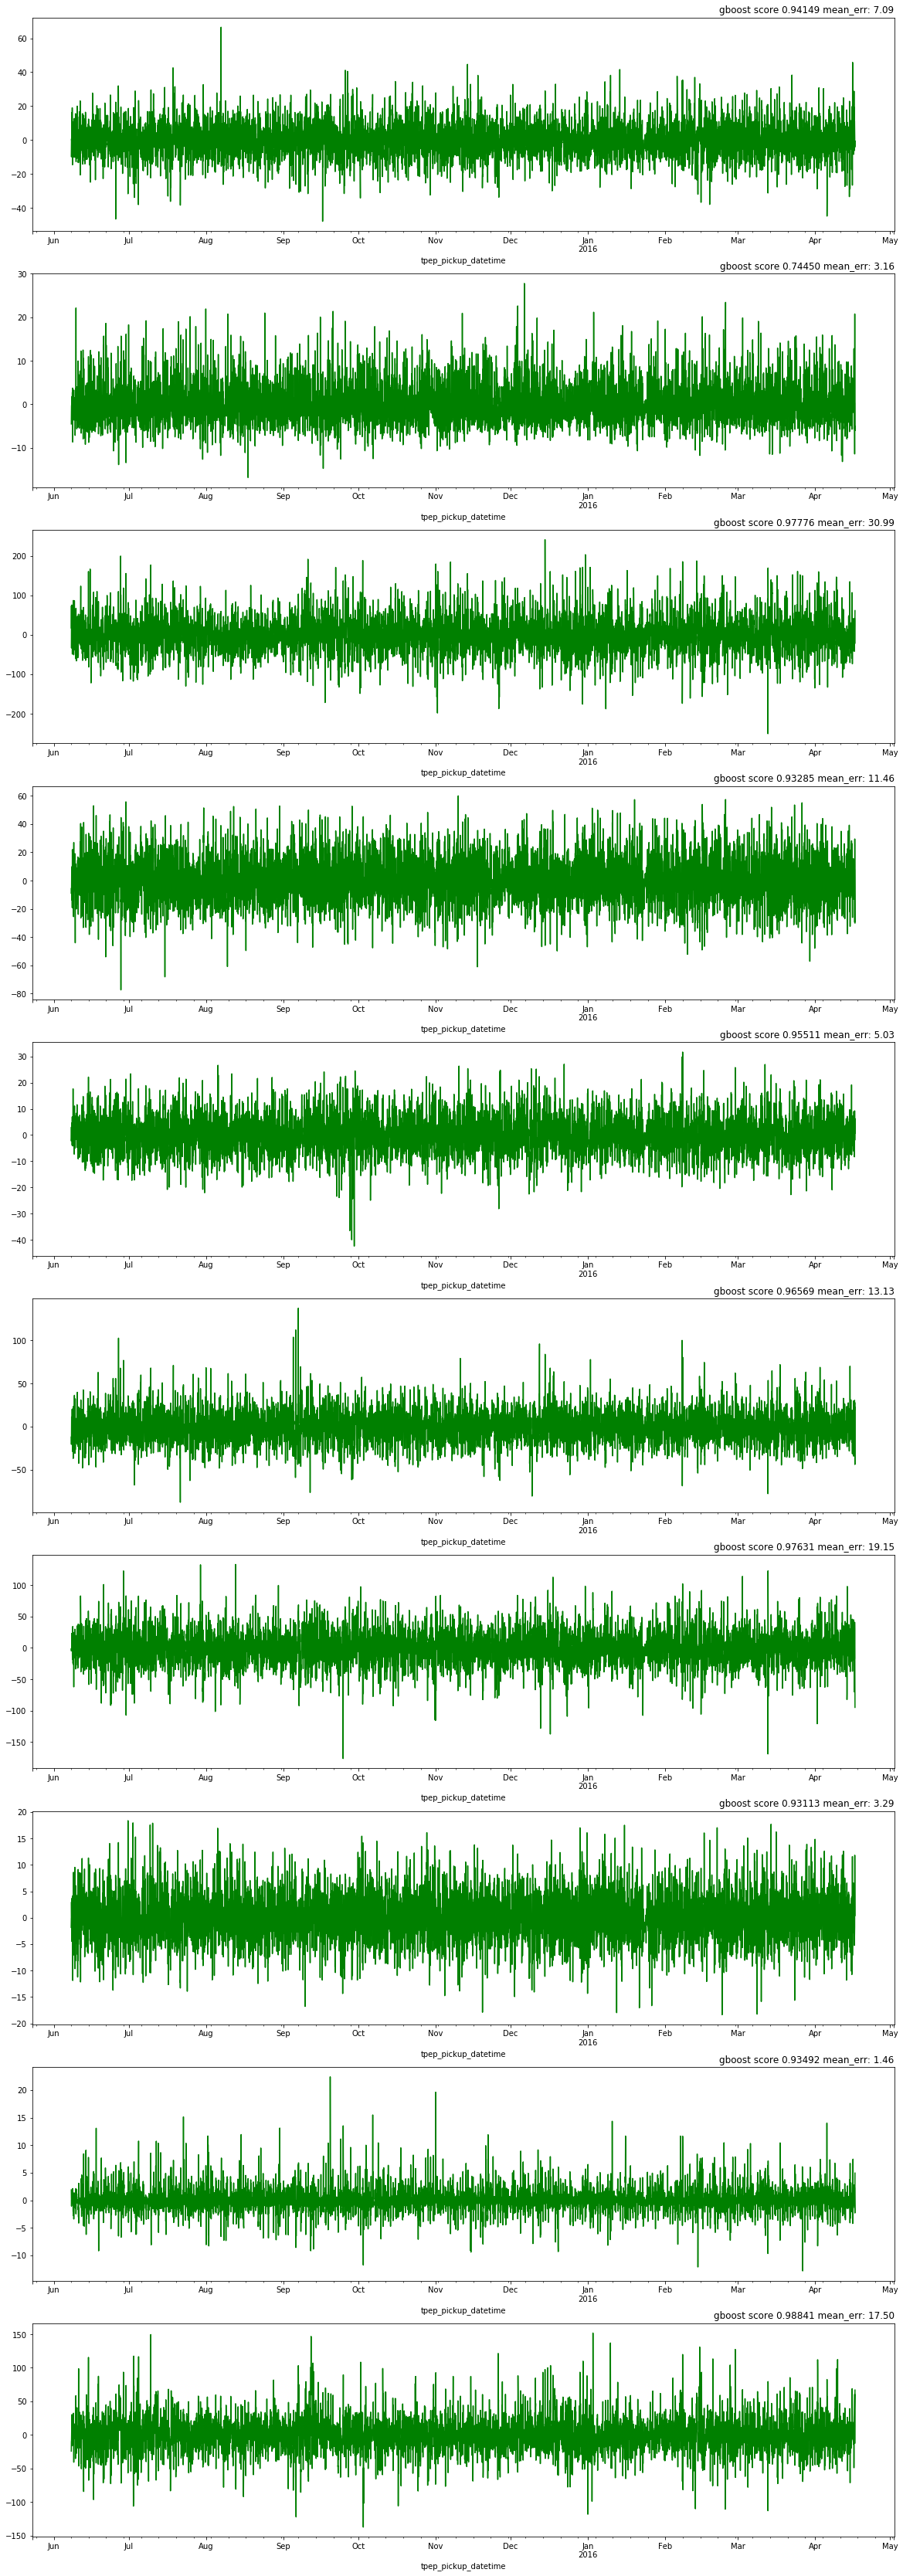

CPU times: user 2min 53s, sys: 1.46 s, total: 2min 54s
Wall time: 32.9 s


In [132]:
%%time
gmodel = XGBRegressor(**params)
fig, axes = plt.subplots(10, 1, figsize=(20,60))
start = 168
end = -168*2
df_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_drop_off(df, col, do_df)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    score = mae(Y, preds)
    df_score.append(score)
    
    df['pred'] = 0
    df.loc[start:end, ['pred']] = preds
    df['pred'] = df['pred'].shift(1)
    df['dif'] = (df[col] - df['pred'])
    
    # plots
    title = "gboost score %.5f"%r2_score(Y, preds)
    title += " mean_err: %.2f" % score
    
    ax.set_title(title, loc='right')
    dif = df['dif'][start+1:end]
    dif.plot(ax=ax, color='g')
    #print("errors for %s" % col, "mean trip count %.0f" % df[col].mean())
    #print(dif[(dif.abs() > max(df[col].mean() / 3, 60))] )
plt.show()

In [133]:
print("\t".join('%.3f'%x for x in df_score))
print("\t".join('%.3f'%x for x in g_score))

7.092	3.164	30.992	11.460	5.026	13.129	19.148	3.288	1.458	17.504
7.254	3.185	32.654	11.733	5.175	13.367	20.282	3.380	1.514	18.127


In [134]:
dif_df = np.array(df_score)
dif = np.array(g_score)
print(dif_df.mean(), dif.mean())

11.22627094567115 11.667103083807808


In [135]:
print(get_X_shifted(df, col).shape[1])
print(get_X_drop_off(df, col, do_df).shape[1])

86
94


Добавив новые параметры, мы добились небольшого но устойчивого увелечения качества предсказания на 10 случайных регионах. Ппробуем подобрать под новое кол-во параметров оптимальные значения параметров модели

In [170]:
start = 169
end = -24

col = str(tests[2])
print(col)
X = get_X_shifted(df, col)[start:end, :]
Y = df[col].shift(-1)[start:end].values
print(X.shape, Y.shape)
print(params)

1233
(7847, 86) (7847,)
{'learning_rate': 0.05, 'n_estimators': 250, 'max_depth': 5, 'nthread': 6}


In [171]:
%%time
# подбор лучших параметров 
from sklearn.model_selection import GridSearchCV
lr_param = params['learning_rate']
n_trees = params['n_estimators']
depth = params['max_depth']
cv_params = {
    "learning_rate": [lr_param - 0.02, lr_param, lr_param + 0.02],
    "n_estimators": [n_trees - 50, n_trees, n_trees + 50]
         }

grid = GridSearchCV(XGBRegressor(nthread=6), cv_params, cv=2, return_train_score=False,
                    scoring='neg_mean_absolute_error')
grid.fit(X, Y)
grid_df = pd.DataFrame.from_dict(grid.cv_results_)

CPU times: user 49.1 s, sys: 112 ms, total: 49.2 s
Wall time: 8.21 s


In [173]:
columns = ['mean_fit_time', 'std_fit_time', 'param_learning_rate', 'param_n_estimators',
           'mean_test_score', 'std_test_score', 'rank_test_score']
grid_df[columns].sort_values(['rank_test_score']).head()

,mean_fit_time,std_fit_time,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,rank_test_score
7,0.393816,0.000024,0.07,250,-54.796383,6.387113,1
8,0.480523,0.001683,0.07,300,-55.109486,6.339819,2
5,0.473252,0.000784,0.05,300,-55.417323,6.505099,3
6,0.324948,0.008187,0.07,200,-55.636005,6.385076,4
4,0.398762,0.002282,0.05,250,-55.968766,6.770798,5


In [174]:
%%time
# подбор лучших параметров 
pre_params = grid.best_params_
lrs = pre_params["learning_rate"]
estims = pre_params["n_estimators"]
cv_params = {
    "learning_rate": [lrs - 0.01, lrs, lrs + 0.01],
    "n_estimators": [estims - 25, estims, estims + 25],
         }

grid = GridSearchCV(XGBRegressor(nthread=6), cv_params, cv=2, return_train_score=False, scoring='neg_mean_absolute_error')
grid.fit(X, Y)

CPU times: user 2min 28s, sys: 1.4 s, total: 2min 29s
Wall time: 25 s


In [179]:
grid_df = pd.DataFrame.from_dict(grid.cv_results_)
grid_df[columns].sort_values(['rank_test_score']).head()

,mean_fit_time,std_fit_time,param_learning_rate,param_n_estimators,mean_test_score,std_test_score,rank_test_score
2,1.871665,0.242152,0.06,275,-54.639724,5.917138,1
4,0.901180,0.560216,0.07,250,-54.796383,6.387113,2
5,2.131550,0.000682,0.07,275,-54.837871,6.193581,3
1,0.456882,0.124398,0.06,250,-54.890363,6.101578,4
7,0.436132,0.102522,0.08,250,-54.949213,6.597379,5


In [180]:
print(grid.best_params_)

{'learning_rate': 0.060000000000000005, 'n_estimators': 275}


In [26]:
bparams = {
    'learning_rate': 0.06,
    'n_estimators': 275
}
bparams['nthread'] = 10
bparams['max_depth'] = params['max_depth']

In [182]:
%%time
gmodel = XGBRegressor(**bparams)
start = 168
end = -168*2
df_bp_score = []

for ind, i in enumerate(tests):
    col = str(i)
    ax = axes[ind]
    X = get_X_drop_off(df, col, do_df)
    
    X = X[start:end, :]
    #  1 hour forward
    Y = df[col].shift(-1)[start:end].values
    
    gmodel.fit(X, Y)
    preds = gmodel.predict(X)
    score = mae(Y, preds)
    df_bp_score.append(score)

CPU times: user 4min 44s, sys: 3.09 s, total: 4min 47s
Wall time: 1min 22s


In [185]:
print("\t".join('%.3f'%x for x in df_score))
print("\t".join('%.3f'%x for x in df_bp_score))

7.092	3.164	30.992	11.460	5.026	13.129	19.148	3.288	1.458	17.504
6.641	2.947	28.455	10.737	4.713	12.150	17.729	3.056	1.380	16.034


In [186]:
dif_bp = np.array(df_bp_score)
print(dif_df.mean(), dif_bp.mean())

11.22627094567115 10.384356414877479


It works!!

Запустим просчет Q за май

In [187]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-04-30 23:00:00', end='2016-05-31 17:00:00')
X_may = get_X(pd.DataFrame(index=timerange))

In [190]:
do_df1 = pd.concat((do_df, do_df_may))

In [193]:
%%time
gmodel = XGBRegressor(**bparams)    

y = []

start = 169
end = -24
time_len = X_may.shape[0]
reg_count = regs.shape[0]
Q = 0

for reg in regs:
    col = str(reg)
    for t in range(6):
        # fit model
        shift = (t+1) * -1
        X_train = get_X_drop_off(df, col, do_df)
        X_train = X_train[start:end, :]
        Y = df[col].shift(shift)[start:end].values
        gmodel.fit(X_train, Y)   

        # getting y_true
        Y = df_may[col].shift(-t).values
        X_test = get_X_drop_off(df1, col, do_df1)
        X_test = X_test[-time_len-6:-6, :]
        
        preds = gmodel.predict(X_test)
        Q += (np.abs(preds - Y[:time_len])).sum()


CPU times: user 3h 50s, sys: 2min, total: 3h 2min 50s
Wall time: 34min 58s


In [194]:
print(Q / (6 * 739 * 102))

18.19125326239723


Половину поездки отыграли

In [195]:
timerange = pd.DatetimeIndex(freq='1H', start = '2016-05-31 23:00:00', end='2016-06-30 17:00:00')
X_june = get_X(pd.DataFrame(index=timerange))
do_df2 = pd.concat((do_df1, do_df_june))
print(X_june.shape)

(715, 64)


In [199]:
%%time

gmodel = XGBRegressor(**bparams)

y = []
time_len = X_june.shape[0]
reg_count = regs.shape[0]
Q = 0
header = 'id,y'

with open('data/output-june-gboost.csv', 'w', newline='\n') as f:
    f.write(header + '\n')
    
    for reg in regs:
        col = str(reg)
        reg_str = col + '_'
        
        preds_to_write = np.zeros((6, time_len))
        
        for t in range(6):
            # fit model
            shift = (t+1) * -1
            X_train = get_X_drop_off(df1, col, do_df1)
            X_train = X_train[start:end, :]
            Y = df1[col].shift(shift)[start:end].values
            gmodel.fit(X_train, Y)

            # getting y_true
            Y = df_june[col].shift(-t).values
            X_test = get_X_drop_off(df2, col, do_df2)
            X_test = X_test[-time_len-6:-6, :]

            preds = gmodel.predict(X_test)
            preds_to_write[t] = preds
            Q += (np.abs(preds - Y[:time_len])).sum()
              
        for ind, date in enumerate(timerange):
            date_str = get_date_str(date)
            for t, val in enumerate(preds_to_write[:, ind], 1):
                row = reg_str + date_str + str(t) + ',%.0f'%abs(round(val))
                f.write(row)
                f.write('\n')
        
        
print(Q / (6 * 102 * 715) )

16.90694973400762
CPU times: user 6h 10min 14s, sys: 4min 56s, total: 6h 15min 10s
Wall time: 1h 12min 40s


Небольшое улучшение, добавление нового признака и усложнении модели оказалось ненапрасным.
31 Eugene K 16.89529

Добавление признаков улучшает прогнозы. Есть пространство для добавления еще большего количества признаков, например погоды или определенных событий (концертов, флеш-мобов, матчей, парадов и так далее) которые также могут внести свой вклад в улучшении качества прогнозов, лучше объясняя большие отклонения данных от прогнозов.

In [33]:
df2[start:].to_csv('data/input.csv', sep=';', header=True)

In [18]:
l_parse_dates = ['tpep_dropoff_datetime']
l_index_col = ['tpep_dropoff_datetime']
do_df = pd.read_csv('data/drop_off.csv', sep=';', parse_dates=l_parse_dates, index_col=l_index_col)

In [34]:
%%time

gmodel = XGBRegressor(**bparams)
start = 168*2
y = []
Q = 0
header = 'id,y'

df_list = []
for t in range(6):
    shift = t + 1
    st = start - shift
    df_pred = pd.DataFrame(index=df2.index[start:])
    for ind, reg in enumerate(regs):
        if ind % 10 == 0:
            print("shift:%d, reg:%d/102"% (shift, ind))
        col = str(reg)

        X = get_X_drop_off(df2, col, do_df)
        X = X[start-shift:-shift, :]
        #  1 hour forward
        Y = df2[col][start:].values

        gmodel.fit(X, Y)
        preds = gmodel.predict(X)
        df_pred[col] = preds.astype(int)
    
    df_pred.to_csv('data/pred%d.csv'%shift, sep =';', header=True)

shift:1, reg:0/102
shift:1, reg:10/102
shift:1, reg:20/102
shift:1, reg:30/102
shift:1, reg:40/102
shift:1, reg:50/102
shift:1, reg:60/102
shift:1, reg:70/102
shift:1, reg:80/102
shift:1, reg:90/102
shift:1, reg:100/102
shift:2, reg:0/102
shift:2, reg:10/102
shift:2, reg:20/102
shift:2, reg:30/102
shift:2, reg:40/102
shift:2, reg:50/102
shift:2, reg:60/102
shift:2, reg:70/102
shift:2, reg:80/102
shift:2, reg:90/102
shift:2, reg:100/102
shift:3, reg:0/102
shift:3, reg:10/102
shift:3, reg:20/102
shift:3, reg:30/102
shift:3, reg:40/102
shift:3, reg:50/102
shift:3, reg:60/102
shift:3, reg:70/102
shift:3, reg:80/102
shift:3, reg:90/102
shift:3, reg:100/102
shift:4, reg:0/102
shift:4, reg:10/102
shift:4, reg:20/102
shift:4, reg:30/102
shift:4, reg:40/102
shift:4, reg:50/102
shift:4, reg:60/102
shift:4, reg:70/102
shift:4, reg:80/102
shift:4, reg:90/102
shift:4, reg:100/102
shift:5, reg:0/102
shift:5, reg:10/102
shift:5, reg:20/102
shift:5, reg:30/102
shift:5, reg:40/102
shift:5, reg:50/102
s

In [31]:
df_pred.head()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2015-06-15 00:00:00,24,59,32,25,75,118,203,286,349,100,...,9,2,7,434,168,143,10,214,51,130
2015-06-15 01:00:00,16,26,12,20,44,71,181,234,281,54,...,8,1,3,230,230,73,26,214,64,84
2015-06-15 02:00:00,7,10,4,7,19,48,76,126,215,35,...,9,0,1,29,14,16,4,38,5,22
2015-06-15 03:00:00,6,9,3,5,17,38,53,83,190,24,...,12,1,0,13,15,5,3,43,0,2
2015-06-15 04:00:00,6,11,4,8,22,38,54,78,124,18,...,12,1,0,10,5,3,0,21,3,1


In [32]:
df_pred.tail()

,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,1630,1684,1733,1734,1783,2068,2069,2118,2119,2168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-06-30 19:00:00,112,181,139,123,342,338,399,388,552,216,...,1,36,6,294,320,116,11,171,108,0
2016-06-30 20:00:00,110,174,152,126,328,364,425,454,565,259,...,1,26,7,301,313,134,17,206,131,0
2016-06-30 21:00:00,139,176,137,134,337,396,494,552,656,250,...,1,20,7,309,319,162,12,190,141,0
2016-06-30 22:00:00,111,159,118,114,310,448,490,513,605,240,...,2,19,6,321,333,156,12,190,140,1
2016-06-30 23:00:00,86,130,73,97,255,399,491,533,659,194,...,4,4,7,350,221,142,27,181,124,0
